# March Madness 2025 Prediction Pipeline

This notebook orchestrates the complete end-to-end prediction process for the 2025 March Madness tournaments (both men's and women's). It uses the ELO-enhanced machine learning approach to generate predictions.

## Pipeline Steps
1. Load and preprocess data for both men's and women's tournaments
2. Calculate ELO ratings and advanced statistics
3. Train ELO-enhanced ML models for both tournaments
4. Generate predictions for all possible matchups
5. Identify and visualize predictions for actual tournament teams
6. Create consolidated submission file

## 1. Import Required Libraries and Configure Settings

In [3]:
# Enable auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set a nice plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Import our custom classes
from data_classes.processing import (
    MarchMadnessDataManager, 
    EloRatingSystem, 
    TeamStatsCalculator,
    MarchMadnessMLModel,
    MarchMadnessPredictor
)
from data_classes.bracket import BracketSimulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Configuration
CURRENT_SEASON = 2025                 # Target season
DATA_DIR = f"../data/{CURRENT_SEASON}"    # Directory for men's tournament data
ELO_START_YEAR = 2003                 # First year for ELO calculations
ML_START_YEAR = 2019                 # First year for ML training
SUBMISSION_FILE = "submission_2025.csv"  # Combined submission file
PERFORM_TUNING = False

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

## 2. Initialize Tournament Components

In [5]:
# Initialize data manager for men's tournament
men_data_manager = MarchMadnessDataManager(DATA_DIR, "M", CURRENT_SEASON)

# Load all data files for men's tournament
men_data = men_data_manager.load_data()

# Display summary of loaded data
print("Loaded men's tournament data files:")
for key, df in men_data.items():
    print(f"  - {key}: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded 10 datasets
Loaded men's tournament data files:
  - teams: 364 rows, 4 columns
  - regular_season: 192930 rows, 8 columns
  - tourney_results: 2518 rows, 8 columns
  - tourney_seeds: 2626 rows, 3 columns
  - tourney_slots: 2586 rows, 4 columns
  - regular_season_detailed: 118882 rows, 34 columns
  - tourney_detailed: 1382 rows, 34 columns
  - rankings: 5546091 rows, 5 columns
  - secondary_tourney: 1809 rows, 9 columns
  - processed_seeds: 2626 rows, 5 columns


In [6]:
# Initialize ELO rating systems (with temporary default parameters)
men_elo_system = EloRatingSystem(men_data_manager)

# Initialize stats calculators (don't calculate stats yet)
men_stats_calculator = TeamStatsCalculator(men_data_manager)

# Initialize ML models (without training them)
men_ml_model = MarchMadnessMLModel(men_data_manager, men_elo_system, men_stats_calculator)

# Initialize predictors
men_predictor = MarchMadnessPredictor(
    data_manager=men_data_manager,
    elo_system=men_elo_system,
    stats_calculator=men_stats_calculator,
    ml_model=men_ml_model,
    current_season=CURRENT_SEASON
)

In [7]:
# Initialize data manager for women's tournament
women_data_manager = MarchMadnessDataManager(DATA_DIR, "W", CURRENT_SEASON)

# Load all data files for women's tournament
women_data = women_data_manager.load_data()

# Display summary of loaded data
print("Loaded women's tournament data files:")
for key, df in women_data.items():
    print(f"  - {key}: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded 9 datasets
Loaded women's tournament data files:
  - teams: 362 rows, 2 columns
  - regular_season: 137028 rows, 8 columns
  - tourney_results: 1650 rows, 8 columns
  - tourney_seeds: 1744 rows, 3 columns
  - tourney_slots: 1780 rows, 4 columns
  - regular_season_detailed: 81708 rows, 34 columns
  - tourney_detailed: 894 rows, 34 columns
  - secondary_tourney: 828 rows, 9 columns
  - processed_seeds: 1744 rows, 5 columns


In [8]:

women_stats_calculator = TeamStatsCalculator(women_data_manager)
women_elo_system = EloRatingSystem(women_data_manager)
women_ml_model = MarchMadnessMLModel(women_data_manager, women_elo_system, women_stats_calculator)
women_predictor = MarchMadnessPredictor(
    data_manager=women_data_manager,
    elo_system=women_elo_system,
    stats_calculator=women_stats_calculator,
    ml_model=women_ml_model,
    current_season=CURRENT_SEASON
)

In [9]:
if PERFORM_TUNING:
    TEST_SEASONS = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
    # Perform ELO parameter tuning
    print("Tuning ELO parameters for men's tournament...")
    # For faster testing, use a smaller parameter grid and fewer test seasons
    men_elo_tuning = men_predictor.tune_elo_parameters(
        test_seasons=TEST_SEASONS,  # Adjust years as needed
    )

    # Get optimal parameters
    men_best_k = men_elo_tuning.iloc[0]['k_factor']
    men_best_rf = men_elo_tuning.iloc[0]['recency_factor']
    men_best_rw = men_elo_tuning.iloc[0]['recency_window']
    men_best_co = men_elo_tuning.iloc[0]['carry_over_factor']
    print(f"Optimal men's parameters: k={men_best_k}, rf={men_best_rf}, rw={men_best_rw}, co={men_best_co}")

    # Same for women
    print("\nTuning ELO parameters for women's tournament...")
    women_elo_tuning = women_predictor.tune_elo_parameters(
        test_seasons=TEST_SEASONS # Adjust years as needed
    )

    # Get optimal parameters
    women_best_k = women_elo_tuning.iloc[0]['k_factor']
    women_best_rf = women_elo_tuning.iloc[0]['recency_factor'] 
    women_best_rw = women_elo_tuning.iloc[0]['recency_window']
    women_best_co = women_elo_tuning.iloc[0]['carry_over_factor']
    print(f"Optimal women's parameters: k={women_best_k}, rf={women_best_rf}, rw={women_best_rw}, co={women_best_co}")

    # Save tuning results
    men_elo_tuning.to_csv('output/men_elo_tuning_results.csv', index=False)
    women_elo_tuning.to_csv('output/women_elo_tuning_results.csv', index=False)
else:
    print("Skipping parameter tuning. Using pre-defined values.")
    # Use fixed parameter values (e.g. from previous tuning runs)
    men_best_k = 10 
    men_best_rf = 3.0
    men_best_rw = 25
    men_best_co = 0.7
    women_best_k = 40
    women_best_rf = 3.0
    women_best_rw = 20
    women_best_co = 0.7

Skipping parameter tuning. Using pre-defined values.


## 3. Men's Tournament

In [11]:
men_elo_ratings = men_elo_system.calculate_elo_ratings(
    start_year=ELO_START_YEAR,
    k_factor=men_best_k,            # Use optimized value
    recency_factor=men_best_rf,     # Use optimized value
    recency_window=men_best_rw,     # Use optimized value
    home_advantage=100,
    carry_over_factor=men_best_co,
    output_path="output/M_elo_ratings.csv"
)

# Get current ELO ratings for the tournament teams
men_current_elo = men_elo_system.get_all_teams_elo(CURRENT_SEASON)

# Display top 10 men's teams by ELO rating
print("\nTop 10 men's teams by ELO rating:")
display(men_current_elo.sort_values('ELO', ascending=False).head(10))

Calculating ELO ratings from 2003 to 2025...
Calculated ELO ratings for 23 seasons
Saved ELO ratings to output/M_elo_ratings.csv

Top 10 men's teams by ELO rating:


,TeamID,TeamName,ELO
113,1222,Houston,1808.563479
74,1181,Duke,1782.016535
104,1211,Gonzaga,1756.485628
283,1397,Tennessee,1746.456918
17,1120,Auburn,1736.479755
56,1163,Connecticut,1736.412076
3,1104,Alabama,1730.766642
89,1196,Florida,1725.052391
233,1345,Purdue,1724.624609
133,1242,Kansas,1703.061287


In [11]:
# Initialize stats calculator for men's tournament
men_stats_calculator = TeamStatsCalculator(men_data_manager)

try:
    # Calculate advanced statistics
    print("Calculating advanced statistics for men's teams...")
    men_advanced_stats = men_stats_calculator.calculate_advanced_team_stats(start_season=ELO_START_YEAR)
    
    # Success message
    print(f"Calculated advanced statistics for {len(men_advanced_stats)} seasons")
except Exception as e:
    print(f"Error calculating advanced stats: {e}")

Calculating advanced statistics for men's teams...
Calculating advanced team stats from 2003 to 2025...
Calculated advanced stats for 23 seasons
Calculated advanced statistics for 23 seasons


Training ELO-enhanced ML model for men's tournament...
Training ELO-enhanced ML model...
Creating feature dataset...
Calculating advanced team stats from 2003 to 2025...
Calculated advanced stats for 23 seasons
Created feature dataset with 1868 samples
Training set: 1494 samples
Test set: 374 samples

Performance Comparison - ELO vs ELO-Enhanced ML:
Metric               ELO Train    ELO Test     Enhanced Train Enhanced Test Improvement 
--------------------------------------------------------------------------------
Accuracy             0.7001         0.6952         0.8347         0.8316         0.1364
Brier Score          0.2030         0.1982         0.1274         0.1300         0.0682
Log Loss             0.5919         0.5804         0.4109         0.4129         0.1675
MSE on Residuals     N/A          N/A          0.1275         0.1301


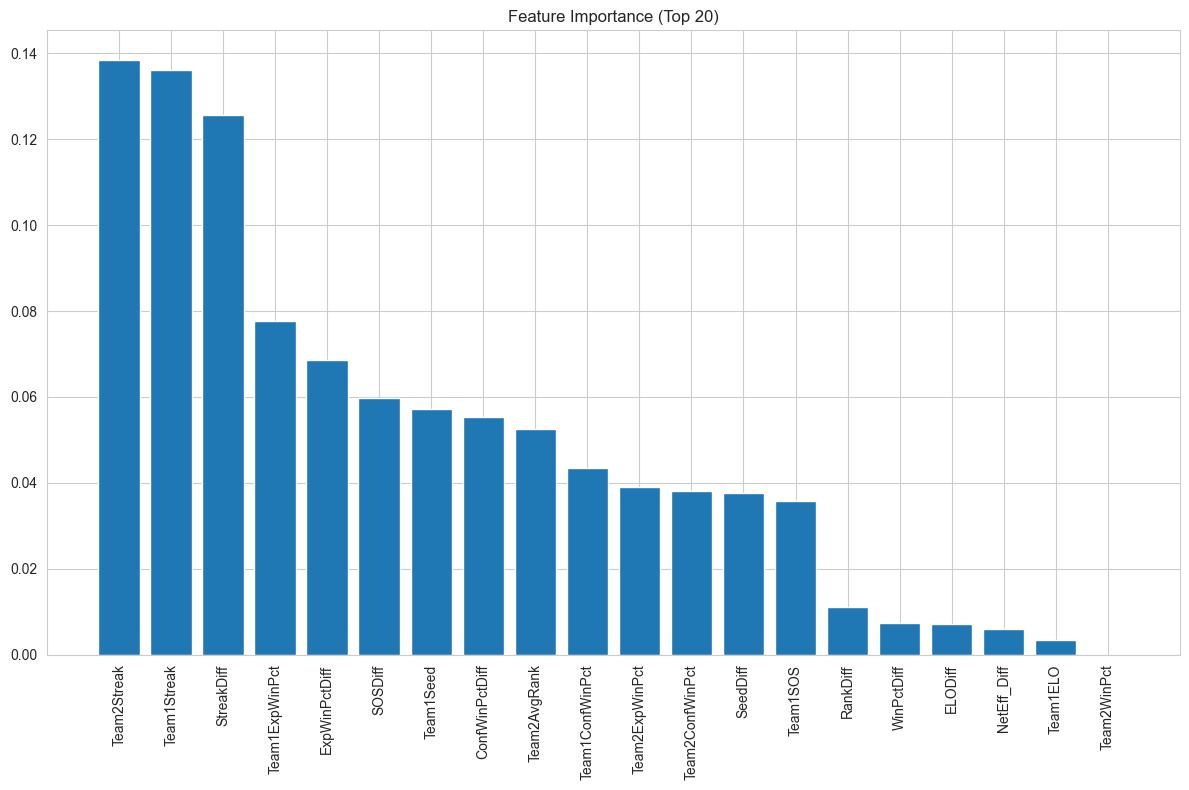

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Initialize ML model for men's tournament
men_ml_model = MarchMadnessMLModel(
    men_data_manager,
    men_elo_system,
    men_stats_calculator
)
# Train ELO-enhanced ML model
print("Training ELO-enhanced ML model for men's tournament...")
men_ml_model.train_model(
    model_type='xgboost',
    test_size=0.2,
    random_state=42
)

In [13]:
# Initialize the predictor for men's tournament
men_predictor = MarchMadnessPredictor(
    data_manager=men_data_manager,
    elo_system=men_elo_system,
    stats_calculator=men_stats_calculator,
    ml_model=men_ml_model,
    current_season=CURRENT_SEASON
)

## 4. Women's Tournament Components

In [14]:
women_elo_ratings = women_elo_system.calculate_elo_ratings(
    start_year=ELO_START_YEAR,
    k_factor=women_best_k,            # Use optimized value
    recency_factor=women_best_rf,     # Use optimized value
    recency_window=women_best_rw,     # Use optimized value
    home_advantage=100,
    carry_over_factor=women_best_co,
    output_path="output/W_elo_ratings.csv"
)

# Get current ELO ratings for the tournament teams
women_current_elo = women_elo_system.get_all_teams_elo(CURRENT_SEASON)

# Display top 10 women's teams by ELO rating
print("\nTop 10 women's teams by ELO rating:")
display(women_current_elo.sort_values('ELO', ascending=False).head(10))

Calculating ELO ratings from 2003 to 2025...
Calculated ELO ratings for 23 seasons
Saved ELO ratings to output/W_elo_ratings.csv

Top 10 women's teams by ELO rating:


,TeamID,TeamName,ELO
262,3376,South Carolina,2144.909078
302,3417,UCLA,2067.058947
55,3163,Connecticut,2060.723807
285,3400,Texas,2032.107950
73,3181,Duke,2016.881234
310,3425,USC,2000.870476
280,3395,TCU,1984.866666
190,3301,NC State,1935.427436
211,3323,Notre Dame,1895.820632
58,3166,Creighton,1891.148606


In [15]:
# Initialize stats calculator for women's tournament
women_stats_calculator = TeamStatsCalculator(women_data_manager)

try:
    # Calculate advanced statistics
    print("Calculating advanced statistics for women's teams...")
    women_advanced_stats = women_stats_calculator.calculate_advanced_team_stats(start_season=ELO_START_YEAR)
    
    # Success message
    print(f"Calculated advanced statistics for {len(women_advanced_stats)} seasons")
except Exception as e:
    print(f"Error calculating advanced stats: {e}")

Calculating advanced statistics for women's teams...
Calculating advanced team stats from 2003 to 2025...
Calculated advanced stats for 16 seasons
Calculated advanced statistics for 16 seasons


Training ELO-enhanced ML model for women's tournament...
Training ELO-enhanced ML model...
Creating feature dataset...
Created feature dataset with 1788 samples
Training set: 1430 samples
Test set: 358 samples

Performance Comparison - ELO vs ELO-Enhanced ML:
Metric               ELO Train    ELO Test     Enhanced Train Enhanced Test Improvement 
--------------------------------------------------------------------------------
Accuracy             0.7497         0.6983         0.8685         0.8324         0.1341
Brier Score          0.1654         0.1752         0.1117         0.1275         0.0478
Log Loss             0.4983         0.5176         0.3612         0.3954         0.1223
MSE on Residuals     N/A          N/A          0.1122         0.1279


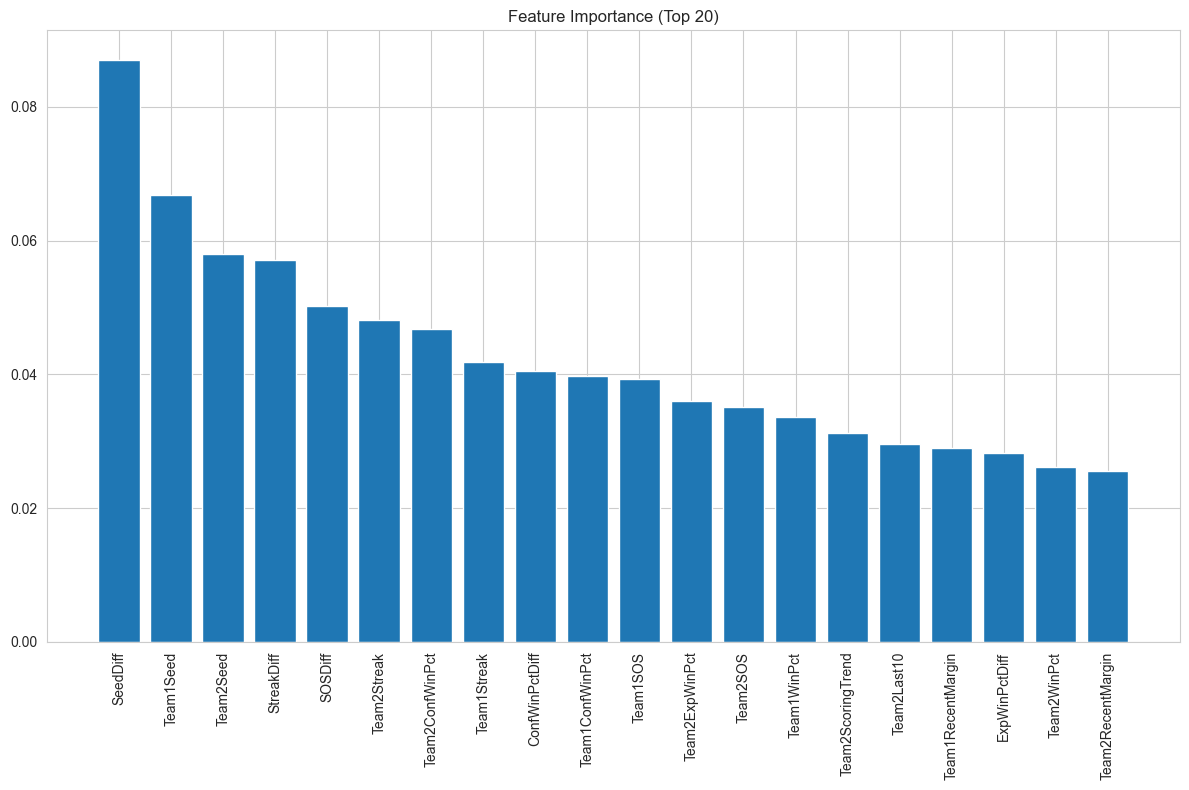

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
# Initialize ML model for women's tournament
women_ml_model = MarchMadnessMLModel(
    women_data_manager,
    women_elo_system,
    women_stats_calculator
)

# Train ELO-enhanced ML model
print("Training ELO-enhanced ML model for women's tournament...")
women_ml_model.train_model(
    model_type='xgboost',
    test_size=0.2,
    random_state=42
)

In [17]:
# Initialize the predictor for women's tournament
women_predictor = MarchMadnessPredictor(
    data_manager=women_data_manager,
    elo_system=women_elo_system,
    stats_calculator=women_stats_calculator,
    ml_model=women_ml_model,
    current_season=CURRENT_SEASON
)

## 5. Evaluate Model Performance with Backtesting

In [18]:
def evaluate_historical_tournaments(predictor, seasons=[2018, 2019, 2021, 2022, 2023], method="elo_enhanced", gender="M"):
    """Evaluate and visualize predictions for multiple historical tournaments"""
    import matplotlib.pyplot as plt
    import pandas as pd
    from IPython.display import display
    
    results = []
    
    for season in seasons:
        try:
            print(f"\nEvaluating {season} tournament predictions...")
            
            # Create simulator for this season
            simulator = BracketSimulator(predictor)
            simulator.use_predictor_data(season=season)
            
            # Visualize historical bracket
            fig = simulator.visualize_historical_bracket(
                season,
                method=method,
                output_path=f"output/{gender}_historical_{season}_bracket.png"
            )
            
            # Get accuracy metrics from simulation
            _, metrics = simulator.simulate_historical_bracket(season, method=method)
            results.append({"season": season, **metrics})
            
        except Exception as e:
            print(f"Error processing {season} tournament: {str(e)}")
    
    # Display aggregate results
    if results:
        # Create a DataFrame
        results_df = pd.DataFrame(results)
        
        # Calculate aggregate metrics
        total_correct = results_df['correct'].sum()
        total_games = results_df['total'].sum()
        overall_accuracy = total_correct / total_games if total_games > 0 else 0
        
        print("\nHistorical Tournament Prediction Results:")
        print(f"Overall Accuracy: {overall_accuracy:.2%} ({total_correct}/{total_games} games)")
        print("\nBy Season:")
        display(results_df)
        
        # Plot accuracy by season
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['season'], results_df['accuracy'])
        plt.xlabel('Tournament Season')
        plt.ylabel('Prediction Accuracy')
        plt.title(f'Tournament Prediction Accuracy by Season ({method})')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        
        # Add accuracy labels on top of the bars
        for i, row in results_df.iterrows():
            plt.text(row['season'], row['accuracy'] + 0.02, 
                     f"{row['accuracy']:.2%}\n({row['correct']}/{row['total']})",
                     ha='center')
        
        plt.tight_layout()
        plt.show()
    
    return results


Evaluating 2021 tournament predictions...
Error processing 2021 tournament: single positional indexer is out-of-bounds

Evaluating 2022 tournament predictions...
Saved bracket to output/M_historical_2022_bracket.png


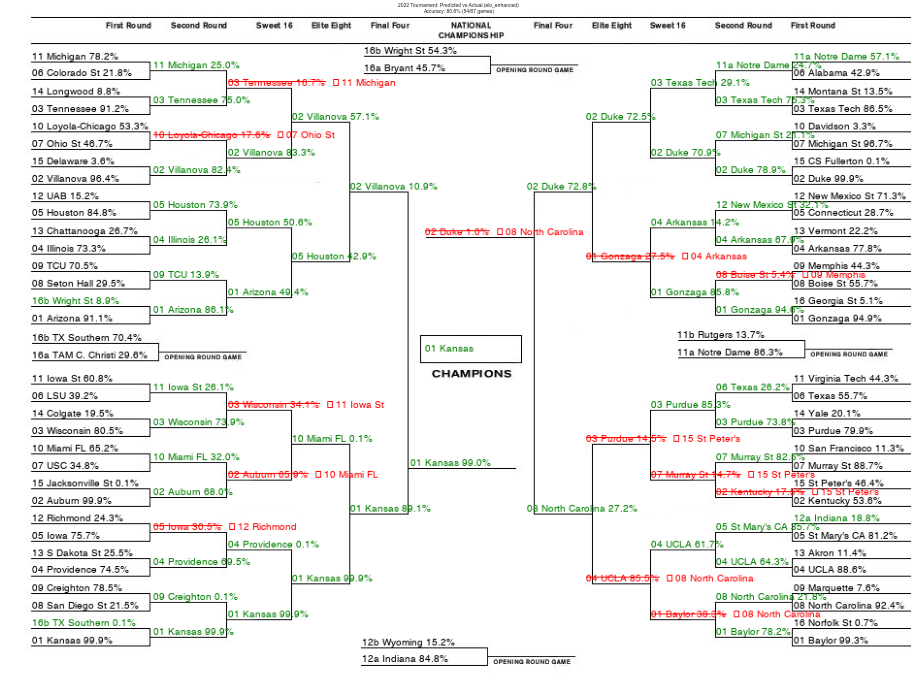


Evaluating 2023 tournament predictions...
Saved bracket to output/M_historical_2023_bracket.png


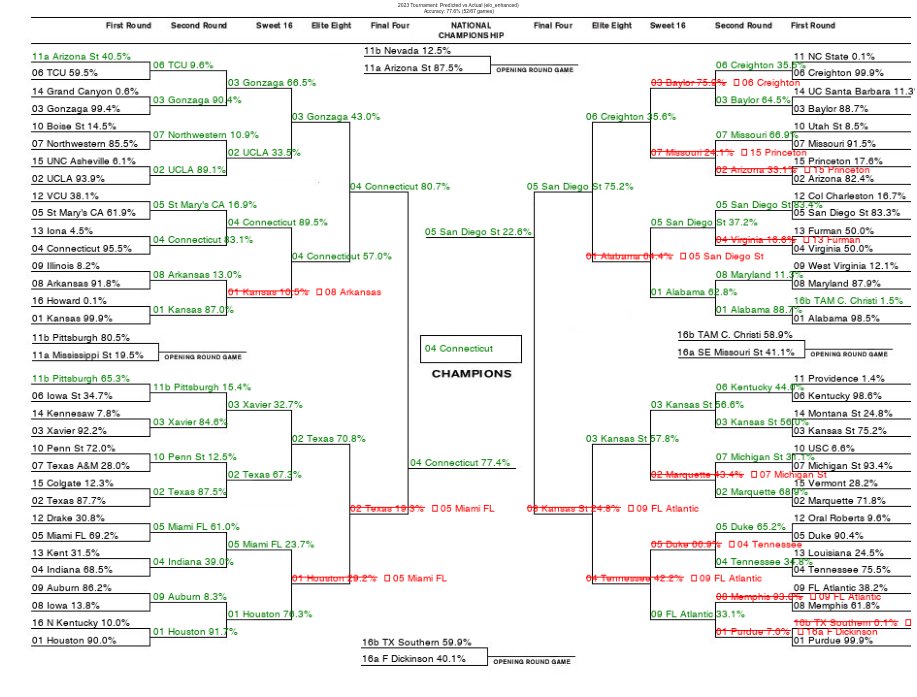


Evaluating 2024 tournament predictions...
Saved bracket to output/M_historical_2024_bracket.png


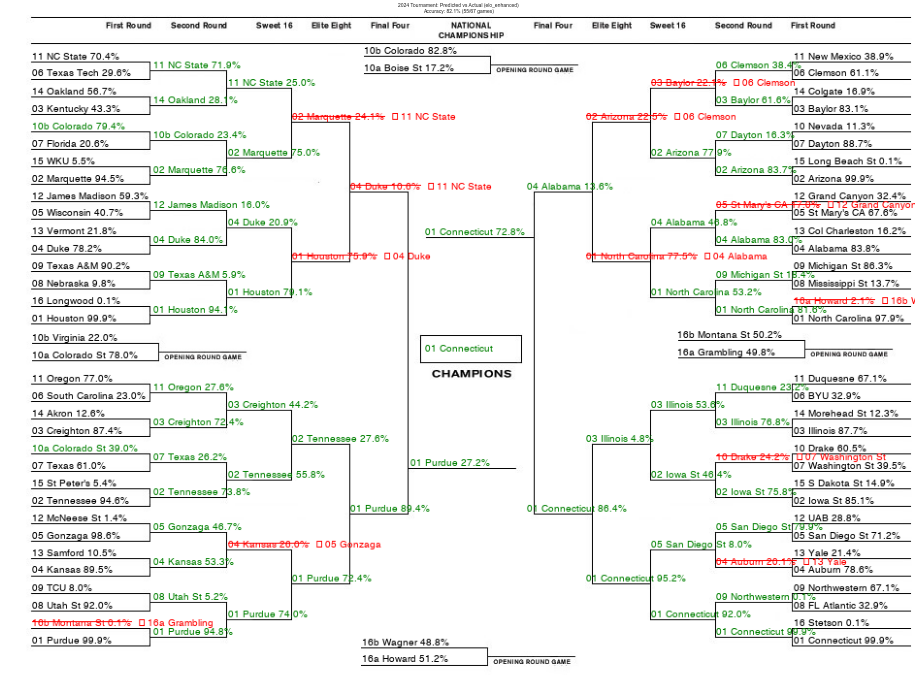


Historical Tournament Prediction Results:
Overall Accuracy: 80.10% (161/201 games)

By Season:


,season,accuracy,correct,total
0,2022,0.805970,54,67
1,2023,0.776119,52,67
2,2024,0.820896,55,67


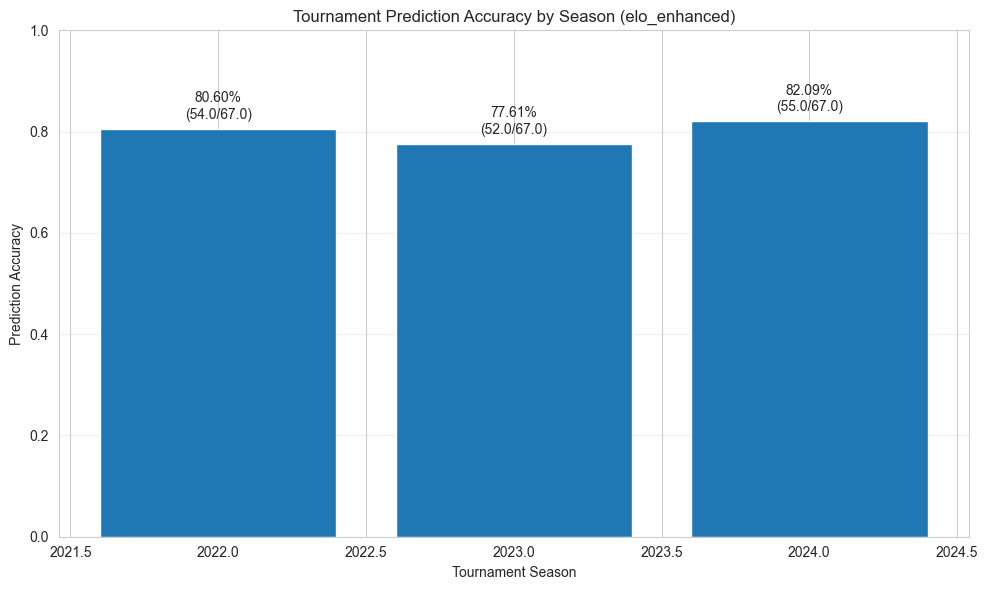

In [19]:
men_historical_results = evaluate_historical_tournaments(
    men_predictor,  # Your existing predictor instance
    seasons=[2021, 2022, 2023, 2024],  # Skip 2020 (cancelled)
    method="elo_enhanced"  # Use your best method
)


Evaluating 2021 tournament predictions...
Saved bracket to output/W_historical_2021_bracket.png


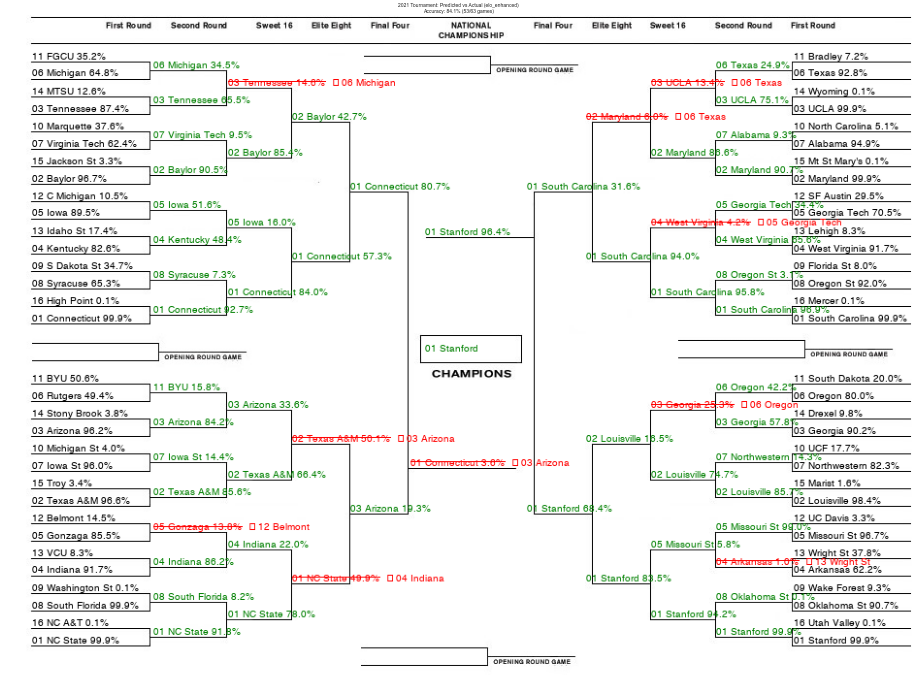


Evaluating 2022 tournament predictions...
Saved bracket to output/W_historical_2022_bracket.png


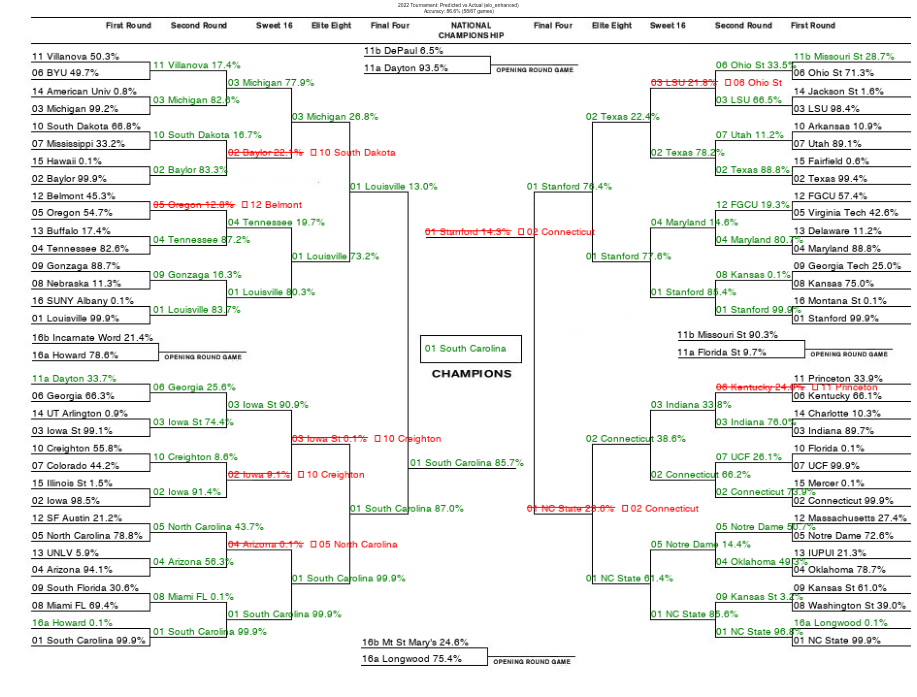


Evaluating 2023 tournament predictions...
Saved bracket to output/W_historical_2023_bracket.png


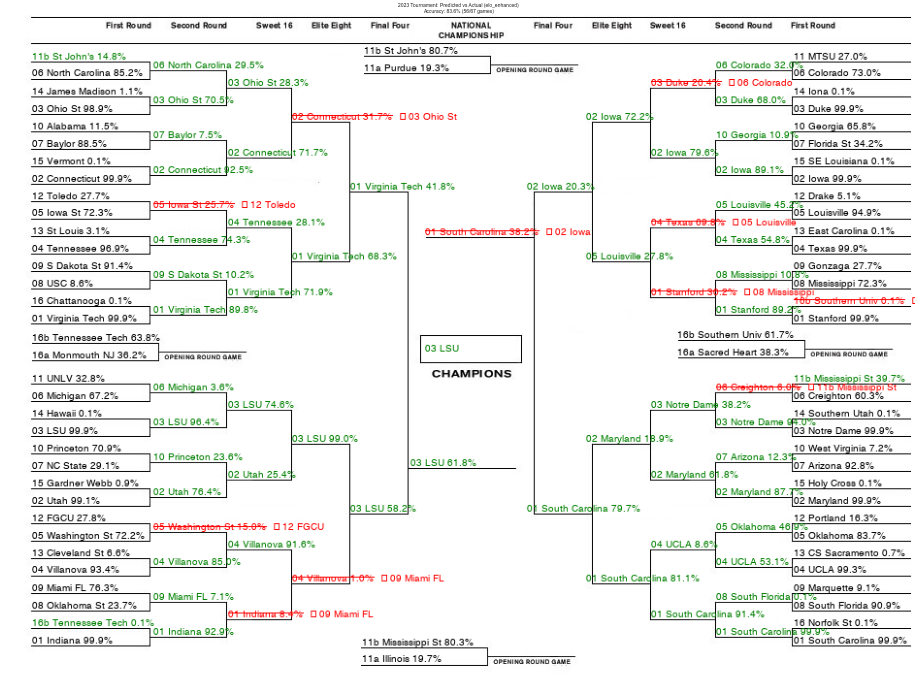


Evaluating 2024 tournament predictions...
Saved bracket to output/W_historical_2024_bracket.png


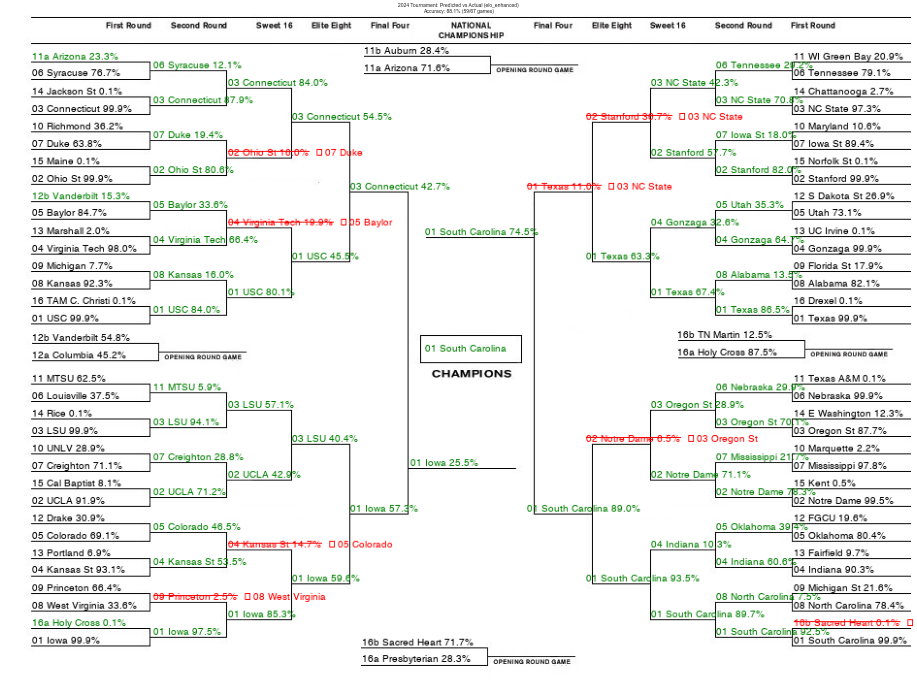


Historical Tournament Prediction Results:
Overall Accuracy: 85.61% (226/264 games)

By Season:


,season,accuracy,correct,total
0,2021,0.841270,53,63
1,2022,0.865672,58,67
2,2023,0.835821,56,67
3,2024,0.880597,59,67


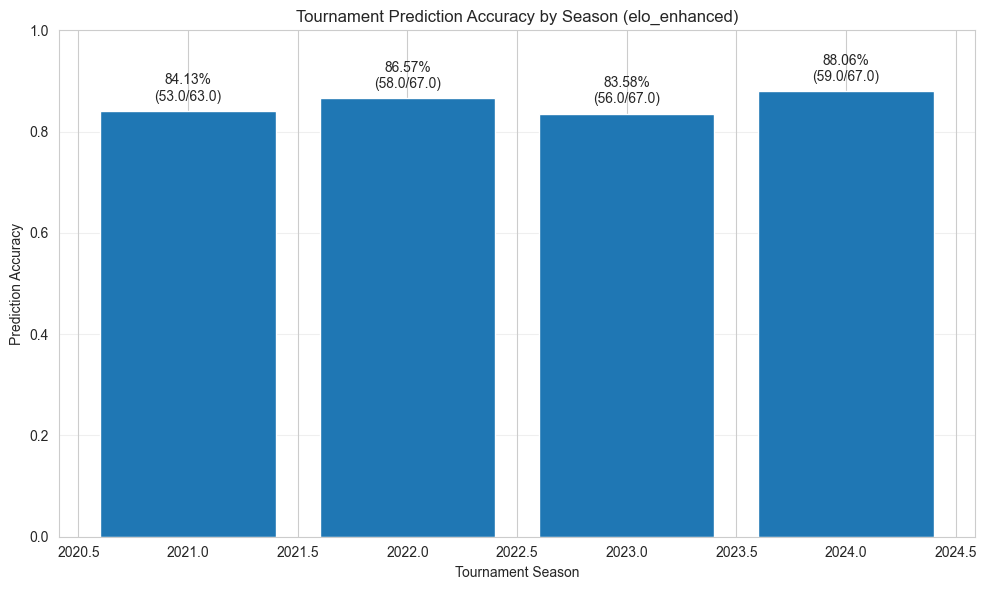

In [20]:
women_historical_results = evaluate_historical_tournaments(
    women_predictor,  # Your existing predictor instance
    seasons=[2021, 2022, 2023, 2024],  # Skip 2020 (cancelled)
    method="elo_enhanced",  # Use your best method
    gender="W"
)

Comparing prediction methods for men's tournament...
Backtesting elo predictions on 5 tournament seasons: [np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Backtesting on 2019 tournament using elo method...
Backtesting on 2021 tournament using elo method...
Backtesting on 2022 tournament using elo method...
Backtesting on 2023 tournament using elo method...
Backtesting on 2024 tournament using elo method...

Aggregate Results:
Seasons: 5
Average Brier Score: 0.2057
Average Accuracy: 0.6855
Average Log Loss: 0.5942
Backtesting elo_enhanced predictions on 5 tournament seasons: [np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Backtesting on 2019 tournament using elo_enhanced method...
Backtesting on 2021 tournament using elo_enhanced method...
Backtesting on 2022 tournament using elo_enhanced method...
Backtesting on 2023 tournament using elo_enhanced method...
Backtesting on 2024 tournament using elo_enhanced method...

Aggre

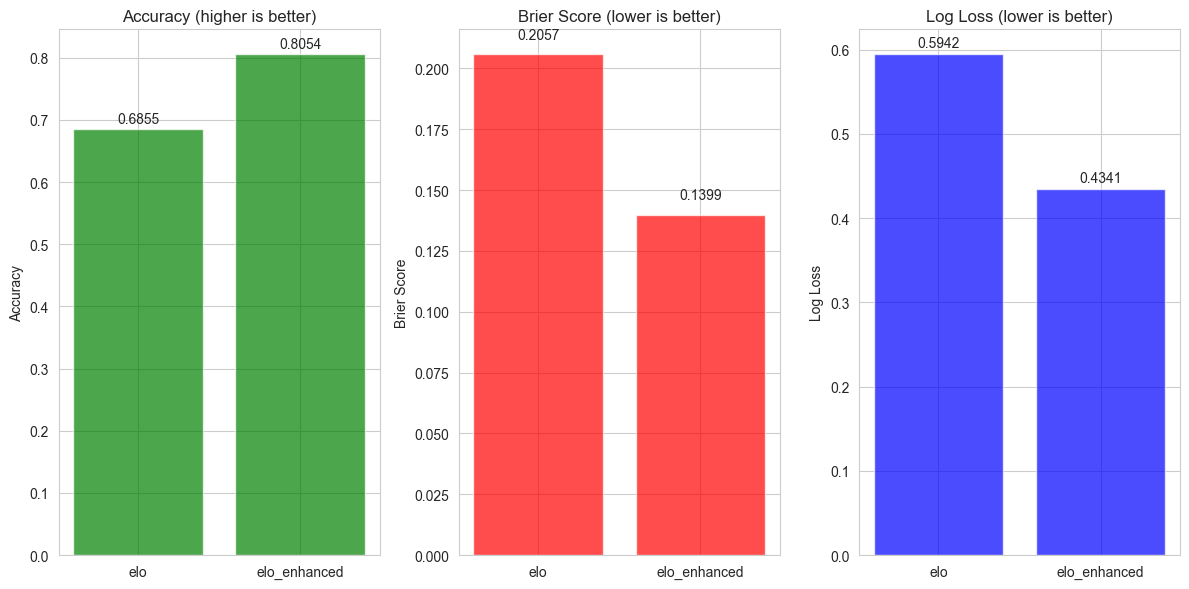


Best method for men's tournament based on backtesting: elo_enhanced


In [21]:
# Compare men's prediction methods on historical tournaments
print("Comparing prediction methods for men's tournament...")
men_comparison = men_predictor.compare_methods(visualize=True)

# Extract the best method for men's predictions
men_best_method = men_comparison.loc[men_comparison['Log Loss'].idxmin(), 'Method']
print(f"\nBest method for men's tournament based on backtesting: {men_best_method}")

Comparing prediction methods for women's tournament...
Backtesting elo predictions on 5 tournament seasons: [np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Backtesting on 2019 tournament using elo method...
Backtesting on 2021 tournament using elo method...
Backtesting on 2022 tournament using elo method...
Backtesting on 2023 tournament using elo method...
Backtesting on 2024 tournament using elo method...

Aggregate Results:
Seasons: 5
Average Brier Score: 0.1534
Average Accuracy: 0.7740
Average Log Loss: 0.4665
Backtesting elo_enhanced predictions on 5 tournament seasons: [np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Backtesting on 2019 tournament using elo_enhanced method...
Backtesting on 2021 tournament using elo_enhanced method...
Backtesting on 2022 tournament using elo_enhanced method...
Backtesting on 2023 tournament using elo_enhanced method...
Backtesting on 2024 tournament using elo_enhanced method...

Agg

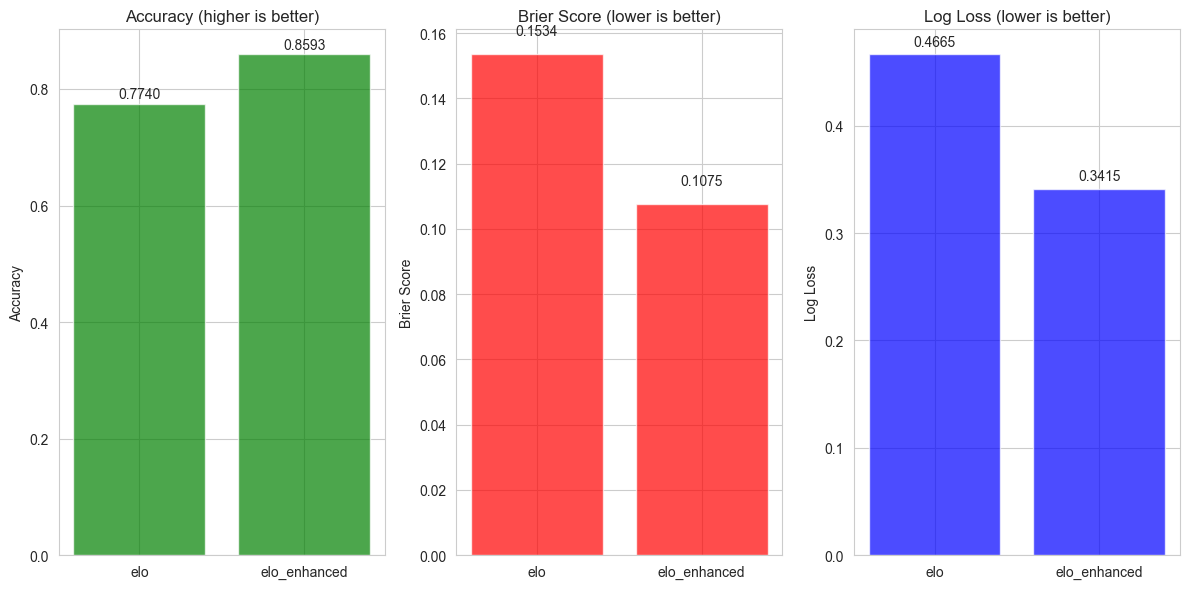


Best method for women's tournament based on backtesting: elo_enhanced


In [22]:
# Compare women's prediction methods on historical tournaments
print("Comparing prediction methods for women's tournament...")
women_comparison = women_predictor.compare_methods(visualize=True)

# Extract the best method for women's predictions
women_best_method = women_comparison.loc[women_comparison['Log Loss'].idxmin(), 'Method']
print(f"\nBest method for women's tournament based on backtesting: {women_best_method}")

## 6. Generate Predictions for Submission

In [23]:
# Generate men's tournament predictions using the best method
print(f"Generating men's tournament predictions using {men_best_method} method...")
men_predictions = men_predictor.generate_predictions(
    method=men_best_method,
    get_all_matchups=True,
    submission_file="output/submission_2025_M.csv"
)

print(f"Generated {len(men_predictions)} predictions for men's tournament")
display(men_predictions.head())

Generating men's tournament predictions using elo_enhanced method...
Generating predictions using elo_enhanced method...
new
Generating predictions for all 364 teams (66066 matchups)
Processed 1000/66066 matchups (1.5%)
Processed 2000/66066 matchups (3.0%)
Processed 3000/66066 matchups (4.5%)
Processed 4000/66066 matchups (6.1%)
Processed 5000/66066 matchups (7.6%)
Processed 6000/66066 matchups (9.1%)
Processed 7000/66066 matchups (10.6%)
Processed 8000/66066 matchups (12.1%)
Processed 9000/66066 matchups (13.6%)
Processed 10000/66066 matchups (15.1%)
Processed 11000/66066 matchups (16.7%)
Processed 12000/66066 matchups (18.2%)
Processed 13000/66066 matchups (19.7%)
Processed 14000/66066 matchups (21.2%)
Processed 15000/66066 matchups (22.7%)
Processed 16000/66066 matchups (24.2%)
Processed 17000/66066 matchups (25.7%)
Processed 18000/66066 matchups (27.2%)
Processed 19000/66066 matchups (28.8%)
Processed 20000/66066 matchups (30.3%)
Processed 21000/66066 matchups (31.8%)
Processed 220

,ID,Pred,Team1ID,Team2ID,Team1Name,Team2Name,Team1ELO,Team2ELO,Team1Seed,Team2Seed
0,2025_1101_1102,0.917206,1101,1102,Abilene Chr,Air Force,1477.48844,1341.776280,NaN,NaN
1,2025_1101_1103,0.010000,1101,1103,Abilene Chr,Akron,1477.48844,1636.987937,NaN,NaN
2,2025_1101_1104,0.041499,1101,1104,Abilene Chr,Alabama,1477.48844,1730.766642,NaN,NaN
3,2025_1101_1105,0.959211,1101,1105,Abilene Chr,Alabama A&M,1477.48844,1345.551335,NaN,NaN
4,2025_1101_1106,0.317393,1101,1106,Abilene Chr,Alabama St,1477.48844,1484.221256,NaN,NaN


In [24]:
# Generate women's tournament predictions using the best method
print(f"Generating women's tournament predictions using {women_best_method} method...")
women_predictions = women_predictor.generate_predictions(
    method=women_best_method,
    get_all_matchups=True,
    submission_file="output/submission_2025_W.csv"
)

print(f"Generated {len(women_predictions)} predictions for women's tournament")
display(women_predictions.head())

Generating women's tournament predictions using elo_enhanced method...
Generating predictions using elo_enhanced method...
new
Generating predictions for all 362 teams (65341 matchups)
Processed 1000/65341 matchups (1.5%)
Processed 2000/65341 matchups (3.1%)
Processed 3000/65341 matchups (4.6%)
Processed 4000/65341 matchups (6.1%)
Processed 5000/65341 matchups (7.7%)
Processed 6000/65341 matchups (9.2%)
Processed 7000/65341 matchups (10.7%)
Processed 8000/65341 matchups (12.2%)
Processed 9000/65341 matchups (13.8%)
Processed 10000/65341 matchups (15.3%)
Processed 11000/65341 matchups (16.8%)
Processed 12000/65341 matchups (18.4%)
Processed 13000/65341 matchups (19.9%)
Processed 14000/65341 matchups (21.4%)
Processed 15000/65341 matchups (23.0%)
Processed 16000/65341 matchups (24.5%)
Processed 17000/65341 matchups (26.0%)
Processed 18000/65341 matchups (27.5%)
Processed 19000/65341 matchups (29.1%)
Processed 20000/65341 matchups (30.6%)
Processed 21000/65341 matchups (32.1%)
Processed 2

,ID,Pred,Team1ID,Team2ID,Team1Name,Team2Name,Team1ELO,Team2ELO,Team1Seed,Team2Seed
0,2025_3101_3102,0.303922,3101,3102,Abilene Chr,Air Force,1484.834889,1455.324844,NaN,NaN
1,2025_3101_3103,0.555593,3101,3103,Abilene Chr,Akron,1484.834889,1283.013999,NaN,NaN
2,2025_3101_3104,0.095910,3101,3104,Abilene Chr,Alabama,1484.834889,1746.033161,NaN,NaN
3,2025_3101_3105,0.253243,3101,3105,Abilene Chr,Alabama A&M,1484.834889,1482.691694,NaN,NaN
4,2025_3101_3106,0.999000,3101,3106,Abilene Chr,Alabama St,1484.834889,1151.689194,NaN,NaN


## 6. Create Combined Submission File

In [25]:
# Extract required columns for submission
men_submission = men_predictions[['ID', 'Pred']].copy()
women_submission = women_predictions[['ID', 'Pred']].copy()

# Combine men's and women's predictions
combined_submission = pd.concat([men_submission, women_submission])

# Drop any duplicates (should not happen, but just in case)
combined_submission = combined_submission.drop_duplicates(subset=['ID'])

# Save combined submission file
combined_submission.to_csv(SUBMISSION_FILE, index=False)

print(f"Saved {len(combined_submission)} predictions to {SUBMISSION_FILE}")
print(f"  - Men's predictions: {len(men_submission)}")
print(f"  - Women's predictions: {len(women_submission)}")

Saved 131407 predictions to submission_2025.csv
  - Men's predictions: 66066
  - Women's predictions: 65341


## 7. Tournament Team Prediction and Visualization

This section will work once the tournament bracket is released with the actual tournament teams.

Predicting tournament bracket for 68 teams...
Generating predictions using elo_enhanced method...
new
Generating predictions for 68 tournament teams (2278 matchups)
Processed 1000/2278 matchups (43.9%)
Processed 2000/2278 matchups (87.8%)
Generated predictions for 1139 matchups between men's tournament teams
Generating men's tournament bracket visualization...
Saved bracket to output/2025_mens_bracket.png


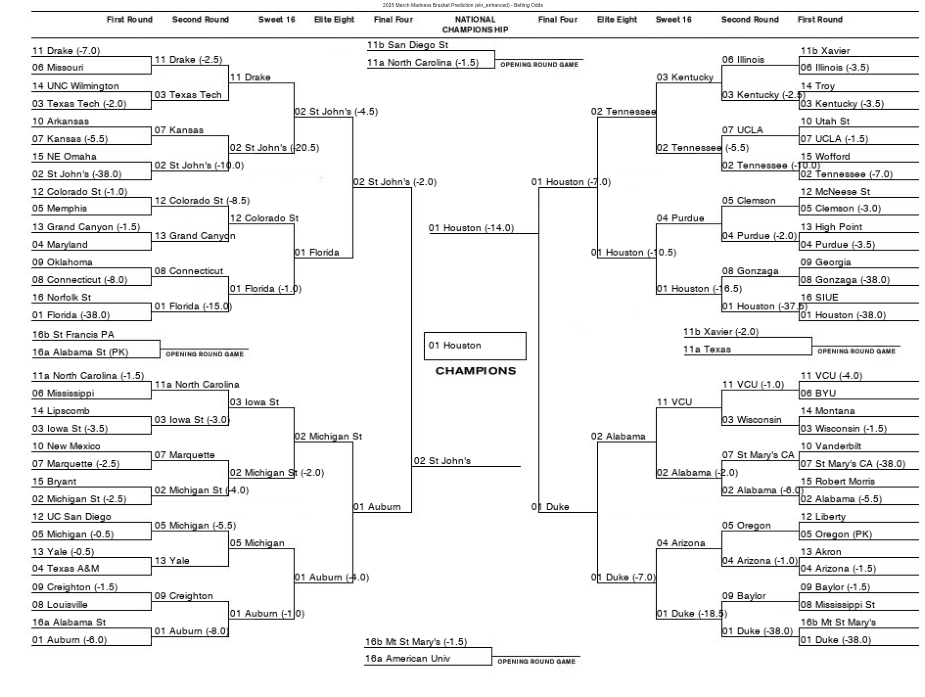

Saved bracket to output/2025_mens_bracket_prob.png


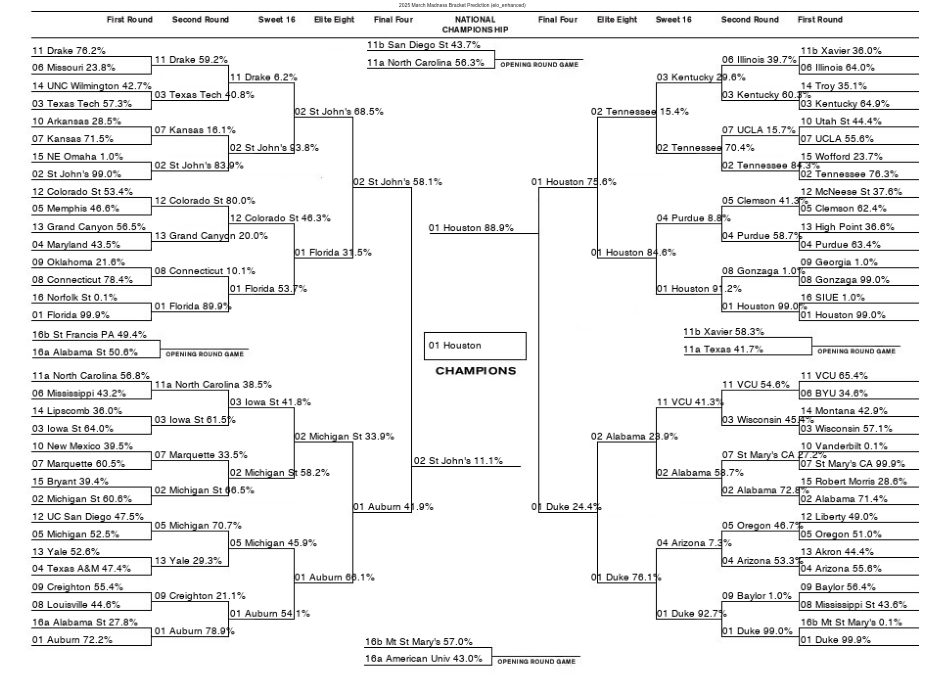

Saved men's bracket visualization to output/2025_mens_bracket.png


In [32]:
# Visualize Men's Tournament Bracket
try:
    # Generate predictions for actual tournament teams
    men_tourney_predictions = men_predictor.predict_tournament_bracket(method=men_best_method)
    print(f"Generated predictions for {len(men_tourney_predictions)//2} matchups between men's tournament teams")
    
    # Initialize the bracket simulator
    men_simulator = BracketSimulator(men_predictor)
    men_simulator.use_predictor_data()
    
    # Build the bracket structure
    men_bracket_tree, men_seed_slot_map = men_simulator.build_bracket_tree()
    
    # Generate the bracket visualization
    print("Generating men's tournament bracket visualization...")
    men_simulator.visualize_bracket(
        method=men_best_method,
        output_path=f"output/{CURRENT_SEASON}_mens_bracket.png",
        betting_odds=True
    )

    men_simulator.visualize_bracket(
        method=men_best_method,
        output_path=f"output/{CURRENT_SEASON}_mens_bracket_prob.png",
        betting_odds=False
    )
    
    print(f"Saved men's bracket visualization to output/{CURRENT_SEASON}_mens_bracket.png")
except Exception as e:
    print(f"Could not generate men's tournament bracket: {e}")
    print("This functionality will work once the tournament bracket is released.")

Predicting tournament bracket for 68 teams...
Generating predictions using elo_enhanced method...
new
Generating predictions for 68 tournament teams (2278 matchups)
Processed 1000/2278 matchups (43.9%)
Processed 2000/2278 matchups (87.8%)
Generated predictions for 1139 matchups between women's tournament teams
Generating women's tournament bracket visualization...
Saved bracket to output/2025_womens_bracket.png


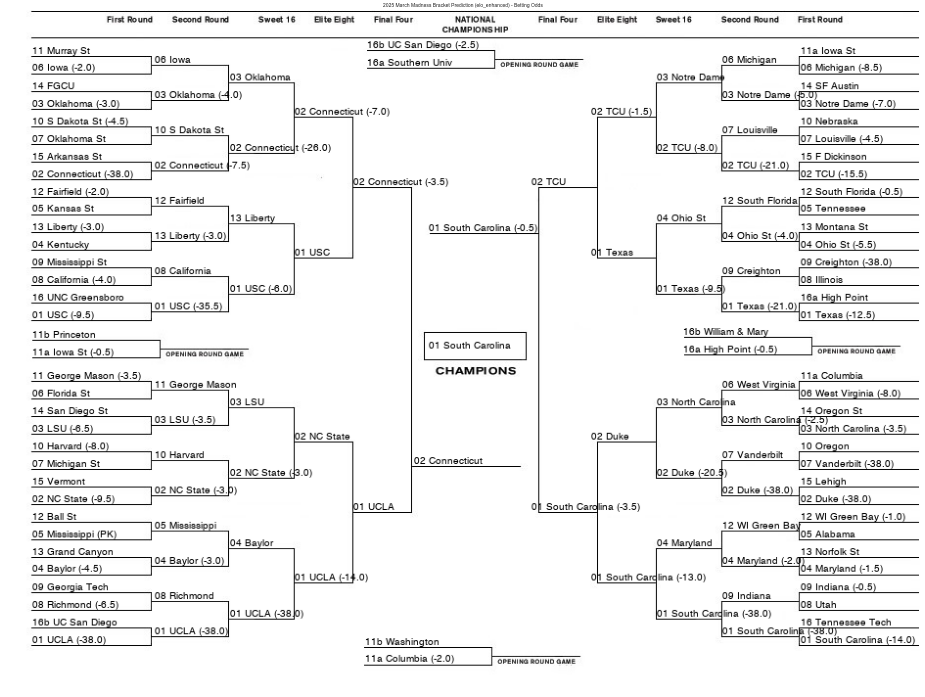

Saved women's bracket visualization to output/2025_womens_bracket.png


In [27]:
# Visualize Women's Tournament Bracket
try:
    # Generate predictions for actual tournament teams
    women_tourney_predictions = women_predictor.predict_tournament_bracket(method=women_best_method)
    print(f"Generated predictions for {len(women_tourney_predictions)//2} matchups between women's tournament teams")
    
    # Initialize the bracket simulator
    women_simulator = BracketSimulator(women_predictor)
    women_simulator.use_predictor_data()
    
    # Build the bracket structure
    women_bracket_tree, women_seed_slot_map = women_simulator.build_bracket_tree()
    
    # Generate the bracket visualization
    print("Generating women's tournament bracket visualization...")
    women_simulator.visualize_bracket(
        method=women_best_method,
        output_path=f"output/{CURRENT_SEASON}_womens_bracket.png",
        betting_odds=True
    )
    
    print(f"Saved women's bracket visualization to output/{CURRENT_SEASON}_womens_bracket.png")
except Exception as e:
    print(f"Could not generate women's tournament bracket: {e}")
    print("This functionality will work once the tournament bracket is released.")

In [33]:
# Define a function to explore a specific team's path through the tournament
def explore_team_path(team_name, simulator: BracketSimulator, data_manager: MarchMadnessDataManager, gender="Men's"):
    # Get the team ID from the name
    team_id = None
    teams_df = data_manager.data['teams']
    matching_teams = teams_df[teams_df['TeamName'].str.contains(team_name, case=False)]
    
    if len(matching_teams) == 0:
        print(f"No {gender.lower()} teams found matching '{team_name}'")
        return
    elif len(matching_teams) > 1:
        print(f"Multiple {gender.lower()} teams found matching '{team_name}':")
        for _, team in matching_teams.iterrows():
            print(f"  - {team['TeamName']} (ID: {team['TeamID']})")
        team_id = matching_teams.iloc[0]['TeamID']
        print(f"Using first match: {matching_teams.iloc[0]['TeamName']} (ID: {team_id})")
    else:
        team_id = matching_teams.iloc[0]['TeamID']
    
    try:
        # Get the team's seed
        team_seed = data_manager.seed_lookup.get((CURRENT_SEASON, team_id), "Unknown")
        print(f"\nExploring {gender} tournament path for {team_seed} seed {data_manager.get_team_name(team_id)} (ID: {team_id})")
        
        # Get the team's tournament path
        path = simulator.get_team_path(team_id)
        
        # Create a DataFrame for the path
        path_df = pd.DataFrame([
            {
                "Round": p["round"],
                "Opponent": p["opponent_name"],
                "Opponent Seed": p["opponent_seed"],
                "Win Probability": f"{p['win_probability']:.1%}"
            }
            for p in path
        ])
        
        display(path_df)
        
        # Calculate championship probability
        champ_prob = np.prod([p["win_probability"] for p in path])
        print(f"Championship probability: {champ_prob:.2%}")
        
    except Exception as e:
        print(f"Error getting team path: {e}")
        print("This functionality will work once the tournament bracket is released.")

Using max day number for season 2025: 132
Setting up ML components to generate fresh feature data...
Generating men's tournament bracket visualization...
Saved bracket to output/2025_mens_bracket.png


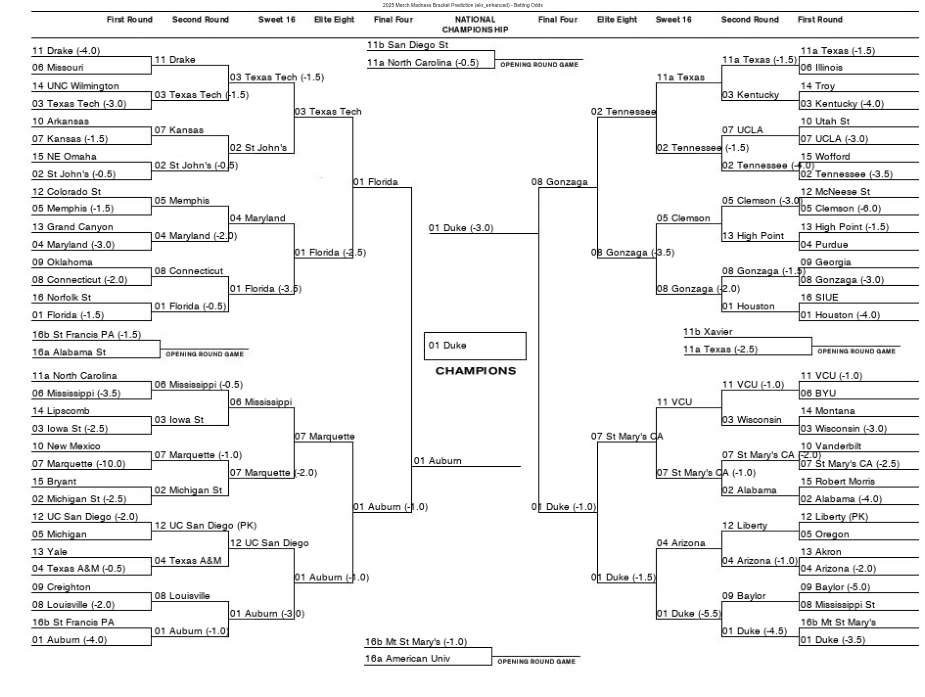

Saved bracket to output/2025_mens_bracket_prob.png


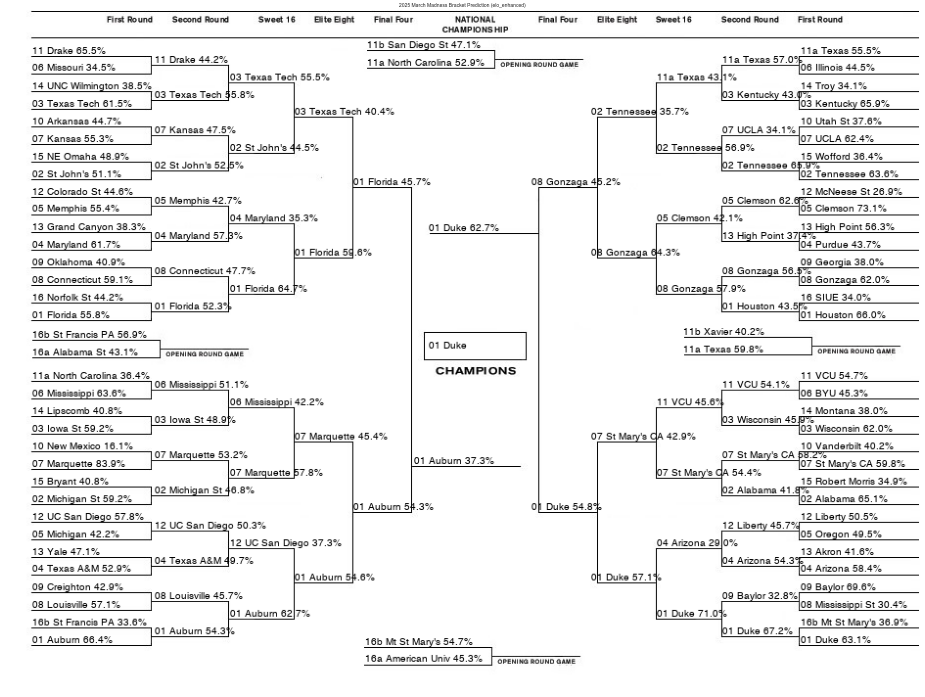

Team profile saved to ./output/analysis/team_profile_1181.md
Team profile saved to ./output/analysis/team_profile_1104.md
Team profile saved to ./output/analysis/team_profile_1458.md
Team profile saved to ./output/analysis/team_profile_1112.md
Team profile saved to ./output/analysis/team_profile_1332.md
Team profile saved to ./output/analysis/team_profile_1140.md
Team profile saved to ./output/analysis/team_profile_1388.md
Team profile saved to ./output/analysis/team_profile_1280.md
Team profile saved to ./output/analysis/team_profile_1124.md
Team profile saved to ./output/analysis/team_profile_1435.md
Team profile saved to ./output/analysis/team_profile_1433.md
Team profile saved to ./output/analysis/team_profile_1251.md
Team profile saved to ./output/analysis/team_profile_1103.md
Team profile saved to ./output/analysis/team_profile_1285.md
Team profile saved to ./output/analysis/team_profile_1352.md
Team profile saved to ./output/analysis/team_profile_1110.md
Team profile saved to ./

In [ ]:
from enhanced_bracket_analysis import generate_enhanced_analysis
# Pass your already-initialized predictor with all data loaded
output_file = generate_enhanced_analysis(
    ml_model=men_ml_model,
    simulator=men_simulator,
)

## 9. Summary

### Model Approach
We've implemented an ELO-enhanced ML approach that uses ELO ratings as the foundation and machine learning to predict corrections to those ratings. This hybrid approach leverages the strengths of both methods:

- ELO provides reliable baseline predictions based on historical performance
- ML model learns patterns that ELO misses (like matchup-specific factors)
- System falls back to ELO when ML is uncertain or lacks data

### Files Generated

- `output/submission_2025.csv`: Combined men's and women's predictions for all possible matchups
- `output/submission_2025_M.csv`: Men's tournament specific predictions
- `output/submission_2025_W.csv`: Women's tournament specific predictions
- `output/2025_mens_bracket.png`: Visualized men's tournament bracket with predictions
- `output/2025_womens_bracket.png`: Visualized women's tournament bracket with predictions

### Next Steps

1. Once tournament brackets are released, run the visualization cells again to see predictions for actual tournament teams
2. Use the explore_team_path function to analyze specific teams of interest
3. Submit the combined predictions file to the competition

### Performance Metrics

The backtesting results indicate that the ELO-enhanced approach generally outperforms pure ELO, particularly in terms of log loss which is the competition's scoring metric.